<a href="https://colab.research.google.com/github/appliedcode/mthree-c422/blob/mthree-422-srilatha/task_c_smf_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# ------------------ CONFIGURATION ------------------
tokens = ["The", "cat", "sat", "on", "the", "mat"]
vocab_size = len(tokens)

#  Experiment with these parameters
embedding_dim = 32      # Try: 8, 16, 32
num_heads = 4           # Try: 2, 4, 8 (must divide embedding_dim)
hidden_dim = 64         # Try: 16, 32, 64

assert embedding_dim % num_heads == 0, "Embedding dim must be divisible by number of heads"
# ---------------------------------------------------

# Initialize random embeddings
torch.manual_seed(0)
embeddings = torch.rand(vocab_size, embedding_dim)

In [15]:
# --------- Self-Attention Block ---------
class SelfAttention(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.scale = embed_dim ** 0.5

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        weights = torch.softmax(scores, dim=-1)
        output = torch.matmul(weights, V)
        return weights, output

# Run Self-Attention
self_attention = SelfAttention(embedding_dim)
attn_weights, attn_output = self_attention(embeddings)

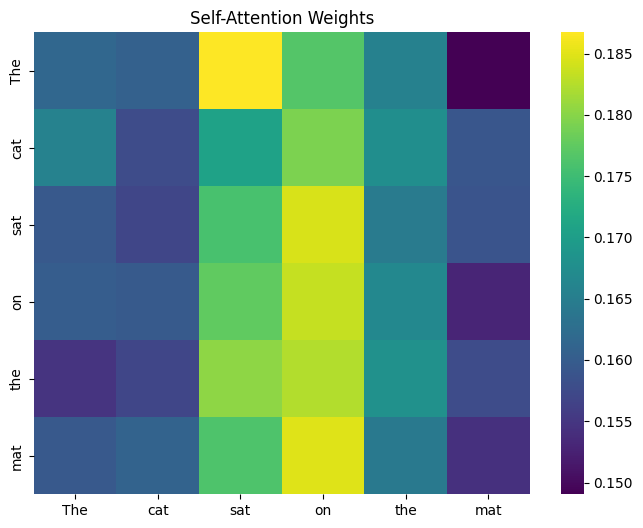

In [16]:
# Visualize self-attention weights
plt.figure(figsize=(8,6))
sns.heatmap(attn_weights.detach().numpy(), xticklabels=tokens, yticklabels=tokens, cmap='viridis')
plt.title("Self-Attention Weights")
plt.show()

In [17]:
# --------- Multi-Head Attention Block ---------
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        batch_size = x.shape[0] if x.ndim == 3 else 1
        Q = self.query(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.key(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.value(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        weights = torch.softmax(scores, dim=-1)
        output = torch.matmul(weights, V)
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.head_dim)

        output = self.out_proj(output)
        return weights, output

# Run Multi-Head Attention
multihead_attention = MultiHeadAttention(embedding_dim, num_heads=num_heads)
multihead_weights, multihead_output = multihead_attention(embeddings.unsqueeze(0))  # batch size = 1

In [18]:
# --------- Feedforward Layer ---------
class FeedForward(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, embed_dim)

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

feed_forward = FeedForward(embedding_dim, hidden_dim=hidden_dim)
ff_output = feed_forward(attn_output)

# --------- Output Inspection ---------
print(" Shapes:")
print("Input embeddings shape:", embeddings.shape)
print("Self-attention output shape:", attn_output.shape)
print("Feedforward output shape:", ff_output.shape)

print("\n Sample token 'The' embeddings:")
print("Input embedding:         ", embeddings[0].detach().numpy())
print("Self-Attention output:   ", attn_output[0].detach().numpy())
print("Feedforward output:      ", ff_output[0].detach().numpy())

 Shapes:
Input embeddings shape: torch.Size([6, 32])
Self-attention output shape: torch.Size([6, 32])
Feedforward output shape: torch.Size([6, 32])

 Sample token 'The' embeddings:
Input embedding:          [0.4962566  0.7682218  0.08847743 0.13203049 0.30742282 0.6340787
 0.4900934  0.89644474 0.45562798 0.6323063  0.34889346 0.4017173
 0.02232575 0.16885895 0.29388845 0.5185218  0.6976676  0.8000114
 0.16102946 0.28226858 0.68160856 0.915194   0.3970999  0.8741559
 0.41940832 0.55290705 0.9527381  0.03616482 0.18523103 0.37341738
 0.30510002 0.9320004 ]
Self-Attention output:    [-7.06458017e-02  9.02842879e-02  7.09245950e-02 -2.87814796e-01
  2.27755327e-02 -4.17728096e-01 -2.53544509e-01 -4.35720712e-01
  3.89845312e-01 -4.93351221e-01  1.51728630e-01 -8.42544138e-02
 -1.04341656e-01 -3.31195205e-01  1.80438459e-01 -3.12154949e-01
 -3.13150525e-01 -3.72744650e-01  5.08898854e-01  3.20640147e-01
 -3.69278161e-04  4.83514555e-02  2.74398476e-01  3.20609152e-01
  9.07141492e-02  7.04